In [10]:
import csv 
import json

csvpath = r'UNFCCC_v26.csv'
jsonpath = r'UNFCCC_v26.json'

convert_csv_into_json(csvpath, jsonpath)


def convert_csv_into_json(csvpath, jsonpath):
    array4json = []
      
    #reading the csv file from csv path
    with (open(csvpath, encoding='utf-8') as csvf): 
        csvReader = csv.DictReader(csvf) 

        rowcount = 0
        for row in csvReader: 
            #Read only Car specific and Total data
            if  row['Pollutant_name'] == 'All greenhouse gases - (CO2 equivalent)' and (row['Sector_name'] == '1.A.3.b.i - Cars'  or row['Sector_name'] == 'Total emissions (UNFCCC)') :
                array4json.append(row)
                print(row['Pollutant_name'])
                rowcount += 1
    with open(jsonpath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(array4json, indent=4)
        jsonf.write(jsonString)
          






All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)


In [21]:
import psycopg2 

createString = """
CREATE TABLE IF NOT EXISTS GreenHouse_CO2 (
Country_code char(20),
Country	varchar(50),
Format_name	varchar(50),
Pollutant_name	varchar(200),
Sector_code	varchar(50),
Sector_name	varchar(300),
Parent_sector_code	varchar(30),
Unit	varchar(30),
Year	integer,
emissions	numeric, 
Notation varchar(30),
PublicationDate integer,
DataSource varchar(30)
);
"""

insertdata = '''COPY GreenHouse_CO2(Country_code, Country, Format_name, Pollutant_name, Sector_code, Sector_name, Parent_sector_code, Unit, Year, emissions) FROM 'UNFCCC_v26.csv' 
DELIMITER ',' 
CSV HEADER;'''

readdata = '''select count(*) from GreenHouse_CO2;'''


In [22]:
print(createString)
print(insertdata)
print(readdata)


CREATE TABLE GreenHouse_CO2 (
Country_code char(20),
Country	varchar(50),
Format_name	varchar(50),
Pollutant_name	varchar(200),
Sector_code	varchar(50),
Sector_name	varchar(300),
Parent_sector_code	varchar(30),
Unit	varchar(30),
Year	integer,
emissions	numeric, 
Notation varchar(30),
PublicationDate integer,
DataSource varchar(30)
);

COPY GreenHouse_CO2(Country_code, Country, Format_name, Pollutant_name, Sector_code, Sector_name, Parent_sector_code, Unit, Year, emissions) FROM 'UNFCCC_v26.csv' 
DELIMITER ',' 
CSV HEADER;
select count(*) from GreenHouse_CO2;


In [51]:
try :
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #dbCursor.execute("drop table GreenHouse_CO2;")
    #dbCursor.execute(createString)
    dbCursor.execute(readdata)
    print (dbCursor.fetchall())
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

[(2080,)]


In [50]:
import csv


try:
    dbConnection = psycopg2.connect(
                            user = "dap",
                            password = "dap",
                            host = "192.168.56.30",
                            port = "5432",
                            database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #insertString = "INSERT INTO GreenHouse_CO2 VALUES ('{}',"+"'{}',"*8+"'to_number({}, '9999999999.99999')','{}','{}','{}')"
    insertString = "INSERT INTO GreenHouse_CO2 VALUES ('{}',"+"'{}',"*8+"cast(coalesce(nullif('{}',''),'0') as float),'{}','{}','{}')"

    #print(insertString)
    with open('UNFCCC_v26.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            #print(insertString.format(*row))
            if  row[3] == 'All greenhouse gases - (CO2 equivalent)' and (row[5] == '1.A.3.b.i - Cars'  or row[5] == 'Total emissions (UNFCCC)') and row[8] != '1985-1987'  :
                dbCursor.execute(insertString.format(*row))
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

In [95]:
readCO2Emissions_cars = '''Select Year,  
    sum(emissions) as CarsEmission
    from GreenHouse_CO2
    where Sector_name = '1.A.3.b.i - Cars' and Country_code = 'EUA'
    group by  Year
'''

readCO2Emissions_ALL = '''Select Year,
    sum(emissions) as TotalEmission
    from GreenHouse_CO2
    where Sector_name = 'Total emissions (UNFCCC)' and Country_code = 'EUA'
    group by  Year
'''


try:
    dbConnection = psycopg2.connect(user = "dap",
    password = "dap",
    host = "192.168.56.30",
    port = "5432",
    database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(readCO2Emissions_cars)
  
    CO2_cars_Only = dbCursor.fetchall(); 

    for i in CO2_cars_Only: 
        print(i) 

    dbCursor.execute(readCO2Emissions_ALL)
    CO2_all_sector = dbCursor.fetchall(); 

    for i in CO2_all_sector: 
        print(i)

    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()


(2008, Decimal('480951.23224'))
(1994, Decimal('413206.13667'))
(2014, Decimal('458349.51112'))
(2010, Decimal('470814.63768'))
(2019, Decimal('483220.2505'))
(1991, Decimal('394510.12301'))
(1996, Decimal('431891.76723'))
(2000, Decimal('457223.42201'))
(2011, Decimal('464550.59445'))
(2017, Decimal('483452.27248'))
(2009, Decimal('476868.11133'))
(2005, Decimal('480541.41953'))
(2013, Decimal('448657.44576'))
(2003, Decimal('477794.44771'))
(2015, Decimal('466627.86469'))
(1993, Decimal('410755.30427'))
(1990, Decimal('388860.35004'))
(1998, Decimal('450957.85969'))
(2007, Decimal('488774.54313'))
(2002, Decimal('473396.40814'))
(2004, Decimal('484375.45057'))
(1997, Decimal('436377.19381'))
(2006, Decimal('482224.75376'))
(2020, Decimal('406560.92397'))
(2001, Decimal('464389.6384'))
(2016, Decimal('477579.92817'))
(1999, Decimal('461226.43213'))
(2012, Decimal('446069.6603'))
(2018, Decimal('480336.43331'))
(1995, Decimal('421372.964'))
(1992, Decimal('407381.07945'))
(2021, Decima

    Year  CarsEmission    AllEmission
0   1990  388860.35004  4866997.59775
1   1991  394510.12301  4761867.85835
2   1992  407381.07945  4611658.68219
3   1993  410755.30427  4533165.14753
4   1994  413206.13667  4509714.05572
5   1995    421372.964  4560147.85956
6   1996  431891.76723  4650978.34252
7   1997  436377.19381  4579674.03966
8   1998  450957.85969  4540461.70646
9   1999  461226.43213   4464183.3389
10  2000  457223.42201   4452021.6243
11  2001   464389.6384  4500256.33936
12  2002  473396.40814  4485727.99169
13  2003  477794.44771  4566353.96585
14  2004  484375.45057  4568722.10312
15  2005  480541.41953  4541881.89835
16  2006  482224.75376  4538039.03394
17  2007  488774.54313  4502767.65157
18  2008  480951.23224  4408412.25575
19  2009  476868.11133  4092959.28975
20  2010  470814.63768  4180741.67268
21  2011  464550.59445  4069866.13577
22  2012   446069.6603  3995310.05734
23  2013  448657.44576  3908576.75698
24  2014  458349.51112  3767739.32618
25  2015  46

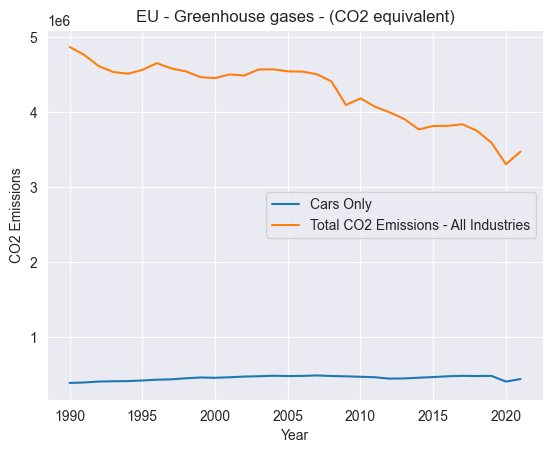

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(CO2_cars_Only, columns =['Year', 'CarsEmission'])
sorted_df_cars = df.sort_values('Year').reindex()
#print(sorted_df_cars)

df1 = pd.DataFrame(CO2_all_sector, columns =['Year', 'AllEmission'])
sorted_df_all = df1.sort_values('Year').reindex()
#print(sorted_df_all)

df_combined = pd.merge(sorted_df_cars, sorted_df_all, on='Year')

print(df_combined)

plt.plot(df_combined['Year'], df_combined['CarsEmission'], label = 'Cars Only')
plt.plot(df_combined['Year'], df_combined['AllEmission'], label = 'Total CO2 Emissions - All Industries')
plt.title("EU - Greenhouse gases - (CO2 equivalent)")
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
#plt.ylim(0, df_combined.max().iloc[2] + 1000000)
plt.show()

